## [Colab version](https://colab.research.google.com/drive/19pR1jRl28pWI9IgKLsz3Qao3XWPnsd7e?usp=sharing)

In [1]:
import random
import numpy as np
import torch
from torchvision import models
from torch.hub import load_state_dict_from_url
import tqdm
from torchvision import transforms
from torchvision import datasets
import pickle

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import os
import pandas as pd

In [2]:
seed = 10
# random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
class ResNet101(models.ResNet):
    def __init__(self, num_classes=1000, pretrained=True, **kwargs):
        # Start with the standard resnet101
        super().__init__(
            block=models.resnet.Bottleneck,
            layers=[3, 4, 23, 3],
            num_classes=num_classes,
            **kwargs
        )
        if pretrained:
            state_dict = load_state_dict_from_url(
                models.resnet.model_urls['resnet101'],
                progress=True
            )
            self.load_state_dict(state_dict)
 
    # Reimplementing forward pass.
    # Replacing the forward inference defined here 
    # http://tiny.cc/23pmmz
    def _forward_impl(self, x):
        # Standard forward for resnet
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
 
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
 
        # Notice there is no forward pass through the original classifier.
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
 
        return x

In [4]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [5]:
# filenames = pd.Series(os.listdir('/content/drive/MyDrive/Colab Notebooks/images/images'))

# files = filenames[filenames.str.len() == 8].values

# len(files)

In [6]:
# identify the path containing all your images
# if you want them to be labeled by country, you will need to sort them into folders

root_path = '/content/drive/MyDrive/Colab Notebooks/images/'

# transform the data so they are identical shapes
transform = transforms.Compose([transforms.Resize((255, 255)),
                                 transforms.ToTensor()])

dataset = ImageFolderWithPaths(root_path, transform=transform)

# load the data
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [7]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(device)

cuda


In [8]:
# initialize model
model = ResNet101(pretrained=True)
model.eval()
model.to(device)

# initialize variables to store results
features = None
labels = []
image_paths = []

print(type(dataloader))

# run the model
for batch in tqdm(dataloader):

  images = batch[0].to(device)
  labels += batch[1]
  image_paths += batch[2]

  output = model.forward(images)
  # convert from tensor to numpy array
  current_features = output.cpu().detach().numpy()

  if features is not None:
      features = np.concatenate((features, current_features))
  else:
      features = current_features

# return labels too their string interpretations
labels = [dataset.classes[e] for e in labels]

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and may be removed in the future. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

<class 'torch.utils.data.dataloader.DataLoader'>


100%|██████████| 293/293 [06:47<00:00,  1.39s/it]


In [9]:
# save the data
np.save('images.npy', images.cpu())
np.save('features.npy', features)
with open('labels.pkl', 'wb') as f:
  pickle.dump(labels, f)
with open('image_paths.pkl', 'wb') as f:
  pickle.dump(image_paths, f)

In [10]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

# run tsne
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(features)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [11]:
# scale and move the coordinates so they fit [0; 1] range
tx = scale_to_01_range(tsne_result[:,0])
ty = scale_to_01_range(tsne_result[:,1])
# tz = scale_to_01_range(tsne_result[:,2])

In [12]:
# image_index = pd.Series(image_paths).apply(lambda x: os.path.basename(x).split('.')[0])

# tsne_coord_df = pd.DataFrame(data={'filename': image_index, 'tsne_x': tx, 'tsne_y': ty, 'tsne_z': tz})

# tsne_coord_df.to_csv('/content/drive/MyDrive/Colab Notebooks/tsne_output.csv')

In [13]:
def compute_plot_coordinates(image, x, y, image_centers_area_size, offset):
    image_height, image_width, _ = image.shape

    # compute the image center coordinates on the plot
    center_x = int(image_centers_area_size * x) + offset

    # in matplotlib, the y axis is directed upward
    # to have the same here, we need to mirror the y coordinate
    center_y = int(image_centers_area_size * (1 - y)) + offset

    # knowing the image center, compute the coordinates of the top left and bottom right corner
    tl_x = center_x - int(image_width / 2)
    tl_y = center_y - int(image_height / 2)

    br_x = tl_x + image_width
    br_y = tl_y + image_height

    return tl_x, tl_y, br_x, br_y

In [14]:
def scale_image(image, max_image_size):
    image_height, image_width, _ = image.shape

    scale = max(1, image_width / max_image_size, image_height / max_image_size)
    image_width = int(image_width / scale)
    image_height = int(image_height / scale)

    image = cv2.resize(image, (image_width, image_height))
    return image

Building the T-SNE plot: 100%|██████████| 9367/9367 [02:03<00:00, 75.78it/s]


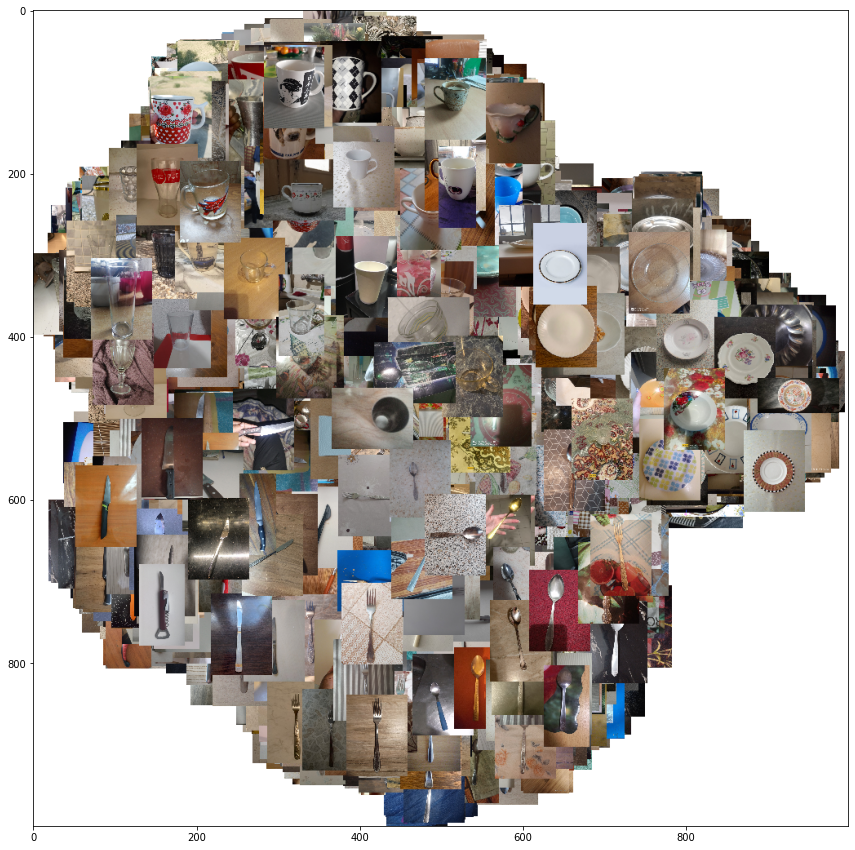

In [15]:
# we'll put the image centers in the central area of the plot
# and use offsets to make sure the images fit the plot

max_image_size = 100
plot_size = 1000

offset = max_image_size // 2
image_centers_area_size = plot_size - 2 * offset

tsne_plot = 255 * np.ones((plot_size, plot_size, 3), np.uint8)

# now we'll put a small copy of every image to its corresponding T-SNE coordinate
for image_path, label, x, y in tqdm(
        zip(image_paths, labels, tx, ty),
        desc='Building the T-SNE plot',
        total=len(image_paths)
):
    image = cv2.imread(image_path)

    # scale the image to put it to the plot
    image = scale_image(image, max_image_size)

    # draw a rectangle with a color corresponding to the image class
    # image = draw_rectangle_by_class(image, label)

    # compute the coordinates of the image on the scaled plot visualization
    tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, image_centers_area_size, offset)

    # put the image to its TSNE coordinates using numpy subarray indices
    tsne_plot[tl_y:br_y, tl_x:br_x, :] = image

plt.figure(figsize=(15, 15))
plt.imshow(tsne_plot[:, :, ::-1])
plt.show()